In [1]:
import gc
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

data_dir = Path.home() / 'Desktop/kaggle/data/lanl'
os.environ['DATA_DIR'] = str(data_dir)

In [2]:
!ls -lh $DATA_DIR

total 6.0G
-rw-r----- 1 maekawa primarygroup  75K May 31 20:54 CatBoost_2019-05-31_test_2.055_train_1.806.csv
-rw-r----- 1 maekawa primarygroup  76K Jun  1 01:18 CatBoost_2019-06-01_test_1.848_train_1.534.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 02:53 CatBoost_2019-06-01_test_1.982_train_1.671.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 15:41 CatBoost_2019-06-01_test_2.008_train_1.667.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 17:34 CatBoost_2019-06-01_test_2.105_train_1.810.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 19:29 CatBoost_2019-06-01_test_2.108_train_1.763.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 19:08 CatBoost_2019-06-01_test_2.112_train_1.830.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 21:12 CatBoost_2019-06-01_test_2.113_train_1.814.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 21:39 CatBoost_2019-06-01_test_2.147_train_1.815.csv
-rw-r----- 1 maekawa primarygroup  75K Jun  1 22:20 CatBoost_2019-06-01_test_2.156_train_1.743.csv

In [3]:
df_train = pd.read_pickle(data_dir / 'df_train.pickle')

In [4]:
testdata_dir = data_dir / 'testdata'
testfiles = list(testdata_dir.iterdir())
len(testfiles)

2624

In [5]:
def load_df(testfile):
    return pd.read_csv(testfile, dtype={'acoustic_data': np.int16})

In [6]:
df_train.shape

(629145480, 2)

In [7]:
df_test0 = load_df(testfiles[0])
df_test0.shape

(150000, 1)

## Feature engineering: time_from_prev_failure

In [8]:
def get_shake_points():
    x = df_train.time_to_failure.values
    return np.where(x[1:] - x[:-1] > 0)[0] + 1

shake_points = get_shake_points()
shake_points

array([  5656574,  50085878, 104677356, 138772453, 187641820, 218652630,
       245829585, 307838917, 338276287, 375377848, 419368880, 461811623,
       495800225, 528777115, 585568144, 621985673])

In [10]:
ttf_array = df_train.time_to_failure.values

df_train['time_from_prev_failure'] = ttf_array[0] - ttf_array

for i, sp in enumerate(tqdm_notebook(shake_points)):
    print(f'Shake {i} at {sp}')
    after_ith_shake_point = df_train.index - sp >= 0
    df_train.time_from_prev_failure = np.where(
        after_ith_shake_point,
        ttf_array[sp] - ttf_array,
        df_train.time_from_prev_failure)

df_train.head()

Shake 0 at 5656574
Shake 1 at 50085878
Shake 2 at 104677356
Shake 3 at 138772453
Shake 4 at 187641820
Shake 5 at 218652630
Shake 6 at 245829585
Shake 7 at 307838917
Shake 8 at 338276287
Shake 9 at 375377848
Shake 10 at 419368880
Shake 11 at 461811623
Shake 12 at 495800225
Shake 13 at 528777115
Shake 14 at 585568144
Shake 15 at 621985673



,acoustic_data,time_to_failure,time_from_prev_failure
0,12,1.4691,0.0
1,6,1.4691,0.0
2,8,1.4691,0.0
3,5,1.4691,0.0
4,8,1.4691,0.0


In [11]:
SEG_ROWS = 150000
START_OFFSET = 5656575
STRIDE = 0.25
NUM_SEGS = int((len(df_train) - START_OFFSET) // (SEG_ROWS * STRIDE))
NUM_SEGS

16626

In [20]:
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
import scipy.stats
from sklearn.linear_model import LinearRegression


def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def feature_from_series(x):
    x = pd.Series(x)
    xv = x.values

    fd = {}
    fd['mean'] = x.mean()
    fd['std'] = x.std()
    fd['max'] = x.max()
    fd['min'] = x.min()
    
    fd['mean_change_abs'] = np.mean(np.diff(xv))
#    fd['mean_change_rate'] = np.mean(np.nonzero((np.diff(xv) / xv[:-1]))[0])
    fd['abs_max'] = np.abs(x).max()
    fd['abs_min'] = np.abs(x).min()
    
    fd['std_first_50000'] = x[:50000].std()
    fd['std_last_50000'] = x[-50000:].std()
    fd['std_first_10000'] = x[:10000].std()
    fd['std_last_10000'] = x[-10000:].std()
    
    fd['avg_first_50000'] = x[:50000].mean()
    fd['avg_last_50000'] = x[-50000:].mean()
    fd['avg_first_10000'] = x[:10000].mean()
    fd['avg_last_10000'] = x[-10000:].mean()
    
#     fd['min_first_50000'] = x[:50000].min()
#     fd['min_last_50000'] = x[-50000:].min()
#     fd['min_first_10000'] = x[:10000].min()
#     fd['min_last_10000'] = x[-10000:].min()

    fd['q01_first_50000'] = np.quantile(xv[:50000], 0.01)
    fd['q01_last_50000'] = np.quantile(xv[-50000:], 0.01)
    fd['q01_first_10000'] = np.quantile(xv[:10000], 0.01)
    fd['q01_last_10000'] = np.quantile(xv[-10000:], 0.01)
    
#     fd['max_first_50000'] = x[:50000].max()
#     fd['max_last_50000'] = x[-50000:].max()
#     fd['max_first_10000'] = x[:10000].max()
#     fd['max_last_10000'] = x[-10000:].max()

    fd['q99_first_50000'] = np.quantile(xv[:50000], 0.99)
    fd['q99_last_50000'] = np.quantile(xv[-50000:], 0.99)
    fd['q99_first_10000'] = np.quantile(xv[:10000], 0.99)
    fd['q99_last_10000'] = np.quantile(xv[-10000:], 0.99)
    
    fd['max_to_min'] = x.max() / np.abs(x.min())
    fd['max_to_min_diff'] = x.max() - np.abs(x.min())
    fd['count_big'] = len(x[np.abs(x) > 500])
    fd['sum'] = x.sum()
    
#     fd['mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xv[:50000]) / xv[:50000][:-1]))[0])
#     fd['mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xv[-50000:]) / xv[-50000:][:-1]))[0])
#     fd['mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xv[:10000]) / xv[:10000][:-1]))[0])
#     fd['mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xv[-10000:]) / xv[-10000:][:-1]))[0])
    
    fd['q95'] = np.quantile(xv, 0.95)
    fd['q99'] = np.quantile(xv, 0.99)
    fd['q05'] = np.quantile(xv, 0.05)
    fd['q01'] = np.quantile(xv, 0.01)
    
    fd['abs_q95'] = np.quantile(np.abs(xv), 0.95)
    fd['abs_q99'] = np.quantile(np.abs(xv), 0.99)
    fd['abs_q05'] = np.quantile(np.abs(xv), 0.05)
    fd['abs_q01'] = np.quantile(np.abs(xv), 0.01)
    
    fd['trend'] = add_trend_feature(x)
    fd['abs_trend'] = add_trend_feature(x, abs_values=True)
    fd['abs_mean'] = np.abs(x).mean()
    fd['abs_std'] = np.abs(x).std()
    
    fd['mad'] = x.mad()
    fd['kurt'] = x.kurtosis()
    fd['skew'] = x.skew()
    fd['med'] = x.median()
    
    fd['Hilbert_mean'] = np.abs(hilbert(x)).mean()
    fd['Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    fd['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    fd['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    fd['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    fd['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    fd['Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    fd['Moving_average_1500_mean'] = x.rolling(window=1500).mean().mean(skipna=True)
    fd['Moving_average_3000_mean'] = x.rolling(window=3000).mean().mean(skipna=True)
    fd['Moving_average_6000_mean'] = x.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    fd['exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    fd['exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    fd['exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    fd['MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    fd['MA_700MA_BB_high_mean'] = (fd['Moving_average_700_mean'] + no_of_std * fd['MA_700MA_std_mean']).mean()
    fd['MA_700MA_BB_low_mean'] = (fd['Moving_average_700_mean'] - no_of_std * fd['MA_700MA_std_mean']).mean()
    fd['MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    fd['MA_400MA_BB_high_mean'] = (fd['Moving_average_700_mean'] + no_of_std * fd['MA_400MA_std_mean']).mean()
    fd['MA_400MA_BB_low_mean'] = (fd['Moving_average_700_mean'] - no_of_std * fd['MA_400MA_std_mean']).mean()
    fd['MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    
    fd['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    fd['q999'] = np.quantile(x,0.999)
    fd['q001'] = np.quantile(x,0.001)
    fd['ave10'] = scipy.stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        fd['ave_roll_std_' + str(windows)] = x_roll_std.mean()
        fd['std_roll_std_' + str(windows)] = x_roll_std.std()
        fd['max_roll_std_' + str(windows)] = x_roll_std.max()
        fd['min_roll_std_' + str(windows)] = x_roll_std.min()
        fd['q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        fd['q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        fd['q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        fd['q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        fd['av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        #fd['av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        fd['abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        fd['ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        fd['std_roll_mean_' + str(windows)] = x_roll_mean.std()
        fd['max_roll_mean_' + str(windows)] = x_roll_mean.max()
        fd['min_roll_mean_' + str(windows)] = x_roll_mean.min()
        fd['q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        fd['q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        fd['q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        fd['q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        fd['av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
#         #fd['av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        fd['abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

    return fd

In [21]:
discriminators_top250 = set([
    'time_from_prev_failure',
    'fftr_max',
] + [
    'ffti_Moving_average_6000_mean',
    'ffti_abs_q01',
    'ffti_av_change_abs_roll_std_10',
    'ffti_av_change_abs_roll_std_100',
    'ffti_av_change_abs_roll_std_1000',
    'ffti_classic_sta_lta3_mean',
    'ffti_mean_change_abs',
    'ffti_min_roll_std_10',
    'ffti_min_roll_std_100',
    'ffti_min_roll_std_1000',
    'ffti_q01_roll_std_100',
    'ffti_q05_roll_std_10',
    'ffti_q05_roll_std_1000',
    'fftr_abs_min',
    'fftr_abs_q01',
    'fftr_max_roll_mean_10',
    'fftr_max_roll_mean_100',
    'fftr_max_to_min_diff',
    'fftr_mean_change_abs',
    'fftr_min_roll_std_10',
    'fftr_min_roll_std_100',
    'fftr_q01_roll_std_10',
    'fftr_q01_roll_std_100',
    'fftr_q05_roll_std_10',
    'fftr_q95_roll_mean_1000',
    'x_abs_trend',
    'x_av_change_abs_roll_mean_10',
    'x_av_change_abs_roll_mean_100',
    'x_av_change_abs_roll_std_10',
    'x_av_change_abs_roll_std_100',
    'x_av_change_abs_roll_std_1000',
    'x_avg_first_10000',
    'x_avg_first_50000',
    'x_avg_last_10000',
    'x_classic_sta_lta2_mean',
    'x_classic_sta_lta4_mean',
    'x_max_first_50000',
    'x_max_roll_mean_1000',
    'x_max_to_min',
    'x_max_to_min_diff',
    'x_min_roll_mean_1000',
    'x_min_roll_std_10',
    'x_min_roll_std_100',
    'x_q01_roll_mean_100',
    'x_q05_roll_mean_100',
    'x_q05_roll_mean_1000',
    'x_q05_roll_std_10',
    'x_q95_roll_mean_1000',
    'x_q99_roll_mean_1000',
    'x_skew',
] + [
    'fftr_abs_max_roll_mean_10',
    'ffti_q01_roll_std_10',
    'fftr_abs_max_roll_mean_100',
    'fftr_min_roll_std_1000',
    'x_q01_roll_mean_1000',
    'ffti_skew',
    'fftr_med',
    'ffti_mean',
    'x_q05_roll_std_100',
    'x_min_roll_mean_100',
    'fftr_av_change_abs_roll_std_10',
    'fftr_q05_roll_mean_1000',
    'fftr_av_change_abs_roll_mean_10',
    'x_avg_last_50000',
    'x_abs_max_roll_mean_1000',
    'ffti_q05_roll_std_100',
    'ffti_avg_first_10000',
    'x_q05_roll_std_1000',
    'ffti_ave10',
    'x_std_roll_mean_1000',
    'x_classic_sta_lta1_mean',
    'ffti_med',
    'fftr_av_change_abs_roll_mean_1000',
    'x_std_first_10000',
    'ffti_q01_roll_std_1000',
    'ffti_trend',
    'x_q95_roll_mean_100',
    'x_min_first_50000',
    'fftr_max_roll_mean_1000',
    'x_min_roll_std_1000',
    'ffti_abs_q05',
    'fftr_q01_roll_std_1000',
    'ffti_kurt',
    'x_av_change_abs_roll_mean_1000',
    'fftr_ave10',
    'x_classic_sta_lta3_mean',
    'fftr_q05_roll_std_100',
    'ffti_Hann_window_mean',
    'fftr_min_roll_mean_1000',
    'fftr_av_change_abs_roll_std_1000',
    'x_q01_roll_std_10',
    'x_q01_roll_std_1000',
    'fftr_avg_first_10000',
    'fftr_q99_roll_mean_1000',
    'x_max_first_10000',
    'ffti_ave_roll_mean_10',
    'x_ave10',
    'ffti_Moving_average_1500_mean',
    'ffti_avg_first_50000',
    'ffti_Moving_average_3000_mean',
] + [
    'x_exp_Moving_average_30000_mean',
    'fftr_av_change_abs_roll_std_100',
    'fftr_abs_trend',
    'ffti_sum',
    'fftr_abs_max_roll_mean_1000',
    'ffti_avg_last_50000',
    'ffti_avg_last_10000',
    'fftr_av_change_abs_roll_mean_100',
    'fftr_avg_last_10000',
    'x_Moving_average_3000_mean',
    'x_min_first_10000',
    'fftr_q95_roll_mean_100',
    'x_exp_Moving_average_3000_mean',
    'fftr_q01_roll_mean_1000',
    'x_q05_roll_mean_10',
    'fftr_max_roll_std_1000',
    'ffti_av_change_abs_roll_mean_10',
    'fftr_Moving_average_6000_mean',
    'fftr_max_roll_std_10',
    'x_q01_roll_std_100',
    'x_q99_roll_mean_100',
    'fftr_q05_roll_std_1000',
    'fftr_avg_last_50000',
    'x_trend',
    'x_min_last_10000',
    'fftr_max_to_min',
    'x_std_first_50000',
    'ffti_ave_roll_mean_100',
    'x_exp_Moving_average_300_mean',
    'ffti_max_roll_std_1000',
    'fftr_trend',
    'fftr_exp_Moving_average_30000_mean',
    'x_max_last_10000',
    'x_max_last_50000',
    'x_std_last_10000',
    'x_iqr',
    'x_Moving_average_6000_mean',
    'ffti_exp_Moving_average_300_mean',
    'ffti_Moving_average_700_mean',
    'ffti_q05_roll_mean_1000',
    'ffti_exp_Moving_average_3000_mean',
    'fftr_abs_q05',
    'x_max',
    'fftr_classic_sta_lta3_mean',
    'ffti_count_big',
    'x_q95_roll_std_1000',
    'fftr_exp_Moving_average_3000_mean',
    'x_Moving_average_1500_mean',
    'x_q95_roll_std_10',
    'x_min_last_50000',
] + [
    'fftr_abs_max_roll_std_10',
    'x_mean',
    'x_Moving_average_700_mean',
    'fftr_std_roll_mean_1000',
    'x_ave_roll_mean_1000',
    'fftr_max_roll_std_100',
    'ffti_av_change_abs_roll_mean_100',
    'ffti_q95_roll_mean_1000',
    'fftr_exp_Moving_average_300_mean',
    'ffti_exp_Moving_average_30000_mean',
    'x_std_last_50000',
    'fftr_q01_roll_mean_100',
    'fftr_avg_first_50000',
    'x_q99_roll_std_1000',
    'x_Hann_window_mean',
    'x_mean_change_abs',
    'x_min_roll_mean_10',
    'fftr_q99_roll_mean_100',
    'x_kurt',
    'fftr_min',
    'ffti_max_roll_std_10',
    'x_max_roll_mean_100',
    'fftr_std_first_10000',
    'ffti_std_roll_mean_1000',
    'ffti_iqr',
    'ffti_ave_roll_mean_1000',
    'x_std_roll_mean_100',
    'fftr_Moving_average_3000_mean',
    'fftr_q05_roll_mean_100',
    'fftr_abs_max_roll_std_1000',
    'fftr_min_roll_mean_100',
    'x_min',
    'fftr_min_roll_mean_10',
    'x_q95_roll_std_100',
    'ffti_av_change_abs_roll_mean_1000',
    'ffti_max_to_min_diff',
    'fftr_max_last_50000',
    'ffti_max_roll_mean_1000',
    'x_max_roll_mean_10',
    'x_max_roll_std_10',
    'ffti_std_roll_mean_100',
    'x_q95_roll_mean_10',
    'ffti_q01_roll_mean_1000',
    'x_max_roll_std_100',
    'fftr_q95_roll_std_100',
    'ffti_min_first_50000',
    'ffti_max_roll_mean_100',
    'ffti_max_roll_mean_10',
    'ffti_q05_roll_mean_100',
    'x_MA_400MA_BB_low_mean'
] + [
    'x_sum',
    'fftr_abs_max_roll_std_100',
    'x_abs_max',
    'x_abs_max_roll_std_10',
    'x_ave_roll_mean_100',
    'x_ave_roll_mean_10',
    'x_abs_max_roll_mean_100',
    'ffti_q99_roll_mean_1000',
    'ffti_abs_max_roll_std_10',
    'fftr_min_first_50000',
    'x_q001',
    'ffti_min_roll_mean_10',
    'fftr_max_last_10000',
    'ffti_min_roll_mean_1000',
    'x_abs_max_roll_mean_10',
    'ffti_min_roll_mean_100',
    'fftr_std_roll_mean_100',
    'ffti_q95',
    'ffti_abs_max_roll_std_1000',
    'fftr_iqr',
    'ffti_q95_roll_mean_100',
    'fftr_Moving_average_700_mean',
    'fftr_count_big',
    'fftr_q95',
    'x_max_roll_std_1000',
    'x_abs_max_roll_std_100',
    'fftr_q999',
    'ffti_abs_max_roll_mean_1000',
    'fftr_ave_roll_mean_1000',
    'ffti_q01_roll_mean_100',
    'fftr_Hann_window_mean',
    'x_MA_700MA_BB_low_mean',
    'x_q01_roll_mean_10',
    'x_Hilbert_mean',
    'fftr_q95_roll_std_10',
    'fftr_ave_roll_mean_10',
    'fftr_Moving_average_1500_mean',
    'ffti_q95_roll_std_100',
    'ffti_max_roll_std_100',
    'fftr_classic_sta_lta4_mean',
    'fftr_q05_roll_mean_10',
    'fftr_q01_roll_mean_10',
    'fftr_q95_roll_mean_10',
    'ffti_abs_max_roll_mean_100',
    'x_q999',
    'x_q99_roll_mean_10',
    'fftr_q95_roll_std_1000',
    'fftr_min_first_10000',
    'ffti_q05_roll_mean_10',
    'ffti_min_last_50000'
])

In [22]:
def create_features(seg_id, seg, X):
    x = pd.Series(seg['acoustic_data'].values)
    x = x - x.mean()   # !!!
    zc = np.fft.fft(x)
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    
    for k, v in feature_from_series(x).items():
        #if k not in discriminators_top250:
            X.loc[seg_id, f'x_{k}'] = v
    for k, v in feature_from_series(realFFT).items():
        #if k not in discriminators_top250:
            X.loc[seg_id, f'fftr_{k}'] = v
    for k, v in feature_from_series(imagFFT).items():
        #if k not in discriminators_top250:
            X.loc[seg_id, f'ffti_{k}'] = v

In [23]:
#X_train = pd.read_pickle(data_dir / 'df_xtrain.pickle')
#y_train = pd.read_pickle(data_dir / 'df_ytrain.pickle')

In [24]:
X_train = pd.DataFrame(index=range(NUM_SEGS), dtype=np.float64)
y_train = pd.DataFrame(index=range(NUM_SEGS), dtype=np.float64, columns=['time_to_failure', 'time_from_prev_failure'])

# iterate over all segments
for seg_id in tqdm_notebook(range(NUM_SEGS)):
    start_seg = START_OFFSET + int(seg_id * SEG_ROWS * STRIDE)
    end_seg = start_seg + SEG_ROWS
    seg = df_train.iloc[start_seg:end_seg]
    create_features(seg_id, seg, X_train)
    y_train.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    y_train.loc[seg_id, 'time_from_prev_failure'] = seg['time_from_prev_failure'].values[-1]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
X_train.to_pickle(data_dir / 'df_xtrain_submean_v5.pickle')
y_train.to_pickle(data_dir / 'df_ytrain_submean_v5.pickle')

In [27]:
submission = pd.read_csv(data_dir / 'sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

for seg_id in tqdm_notebook(X_test.index):
    seg = load_df(testdata_dir / (seg_id + '.csv'))
    create_features(seg_id, seg, X_test)

In [28]:
X_test.to_pickle(data_dir / 'df_xtest_v5.pickle')

In [29]:
print("Train X: {} y: {} Test X: {}".format(X_train.shape, y_train.shape, X_test.shape))

Train X: (16626, 381) y: (16626, 2) Test X: (2624, 381)


In [30]:
X_test.head().T

seg_id,seg_00030f,seg_0012b5,seg_00184e,seg_003339,seg_0042cc
x_mean,-2.520058e-16,-1.985730e-16,-2.228262e-16,-3.024070e-16,2.611008e-16
x_std,4.893690e+00,5.922839e+00,6.946990e+00,4.114147e+00,5.797164e+00
x_max,1.105082e+02,1.478288e+02,2.433897e+02,8.046853e+01,1.728717e+02
x_min,-7.949178e+01,-1.441712e+02,-1.976103e+02,-9.753147e+01,-1.511283e+02
x_mean_change_abs,2.666684e-05,-1.333342e-05,-2.000013e-05,4.666698e-05,-6.666711e-06
x_abs_max,1.105082e+02,1.478288e+02,2.433897e+02,9.753147e+01,1.728717e+02
x_abs_min,4.917800e-01,1.711533e-01,3.897400e-01,4.685267e-01,1.283400e-01
x_std_first_50000,5.350451e+00,6.249515e+00,9.793473e+00,3.664088e+00,5.321133e+00
x_std_last_50000,4.793876e+00,4.147562e+00,5.225913e+00,3.480840e+00,7.486142e+00
x_std_first_10000,5.226846e+00,3.523253e+00,3.950119e+00,4.001275e+00,5.214578e+00


In [31]:
del df_train

In [32]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [33]:
train_columns = list(X_train.columns)
# for f in discriminators_top250:
#     if f in train_columns:
#         train_columns.remove(f)

In [34]:
%%time

PREDICTION = True
y_train_label = y_train.time_from_prev_failure
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=False, random_state=43)

oof = np.zeros(len(X_train))
train_score = []
fold_idxs = []
if PREDICTION: 
    predictions = np.zeros(len(X_test))

feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train_label.values)):
    strLog = "# Fold {}".format(fold_)
    print(strLog)
    fold_idxs.append(val_idx)

    X_tr, X_val = X_train[train_columns].iloc[trn_idx], X_train[train_columns].iloc[val_idx]
    y_tr, y_val = y_train_label.iloc[trn_idx], y_train_label.iloc[val_idx]

    model = CatBoostRegressor(n_estimators=25000, verbose=-1, objective="MAE", loss_function="MAE", boosting_type="Ordered", task_type="GPU")
    model.fit(X_tr, 
              y_tr, 
              eval_set=[(X_val, y_val)], 
              verbose=2500, 
              early_stopping_rounds=500)
    oof[val_idx] = model.predict(X_val)

    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    if PREDICTION:
        predictions += model.predict(X_test[train_columns]) / folds.n_splits
    train_score.append(model.best_score_['learn']["MAE"])

cv_score = mean_absolute_error(y_train_label, oof)
print(f"After {n_fold} test_CV = {cv_score:.3f} | train_CV = {np.mean(train_score):.3f} | {cv_score-np.mean(train_score):.3f}", end=" ")

# Fold 0
0:	learn: 5.5352538	test: 5.8373968	best: 5.8373968 (0)	total: 82.5ms	remaining: 34m 21s
2500:	learn: 1.1667952	test: 1.4935023	best: 1.4934738 (2495)	total: 3m 24s	remaining: 30m 37s
5000:	learn: 1.0641041	test: 1.4859319	best: 1.4858901 (4993)	total: 6m 59s	remaining: 27m 56s
7500:	learn: 0.9834738	test: 1.4816666	best: 1.4816180 (7435)	total: 10m 37s	remaining: 24m 46s
10000:	learn: 0.9139065	test: 1.4800785	best: 1.4800777 (9995)	total: 14m 19s	remaining: 21m 29s
bestTest = 1.47982177
bestIteration = 10108
Shrink model to first 10109 iterations.
# Fold 1
0:	learn: 5.7829175	test: 4.8468815	best: 4.8468815 (0)	total: 79.7ms	remaining: 33m 11s
bestTest = 1.177836584
bestIteration = 703
Shrink model to first 704 iterations.
# Fold 2
0:	learn: 5.4146810	test: 6.3198661	best: 6.3198661 (0)	total: 76.1ms	remaining: 31m 42s
2500:	learn: 1.1000958	test: 1.7854200	best: 1.7854200 (2500)	total: 3m 26s	remaining: 31m 1s
5000:	learn: 0.9916161	test: 1.7778298	best: 1.7778166 (4994)	to

In [35]:
X_train['time_from_prev_failure'] = oof
X_train.to_pickle(data_dir / 'df_xtrain_extra_v5.pickle')

In [36]:
X_test['time_from_prev_failure'] = predictions
X_test.to_pickle(data_dir / 'df_xtest_extra_v5.pickle')

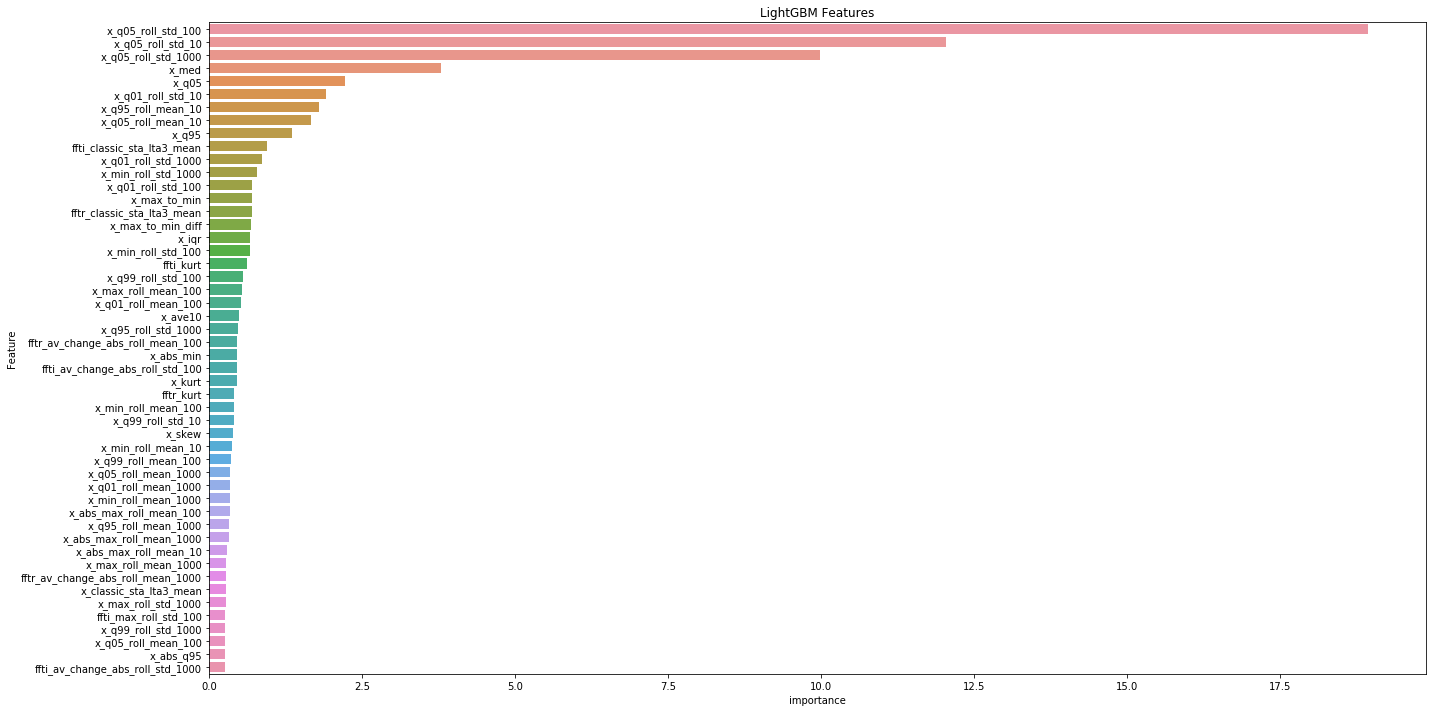

In [37]:
feature_imp = (
 feature_importance_df
 .groupby('Feature')
 .importance.mean()
 .reset_index()
)

plt.figure(figsize=(20, 10))
sns.barplot(x="importance", y="Feature", data=feature_imp.sort_values(by="importance", ascending=False).head(50))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()